
Created on Fri Apr 19 18:00:00 2018

@author: Jesús García

ponemos la info a DEBUG para tener todas las informaciones utiles  
descargando si no está en el disco... 
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
-------------------- 
Step  >>>> Split into a training set and a test set using a stratified k fold  
-------------------- 
Step  >>>>  Compute a PCA   
Extracting the top 150 eigenfaces from 966 faces
done in 0.370s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.016s
-------------------- 
Step  >>>>  Train a SVM classification model  


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklea

done in 24.219s
Best estimator found by grid search:
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Fitting the classifier to the training set
done in 24.567s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
-------------------- 
Step  >>>>   PREDICTING    
Predicting people's names on the test set
done in 0.047s
                   precision    recall  f1-score   support

     Ariel Sharo

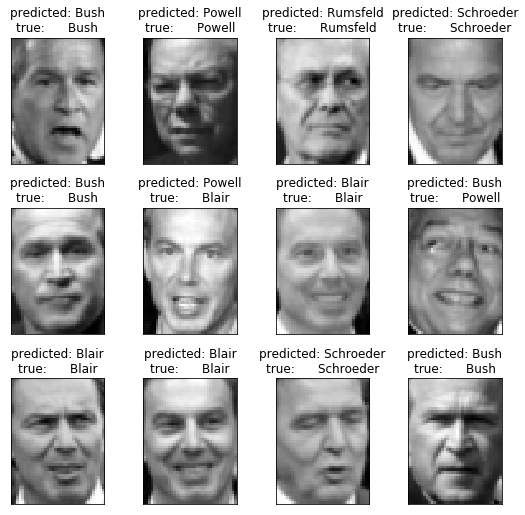

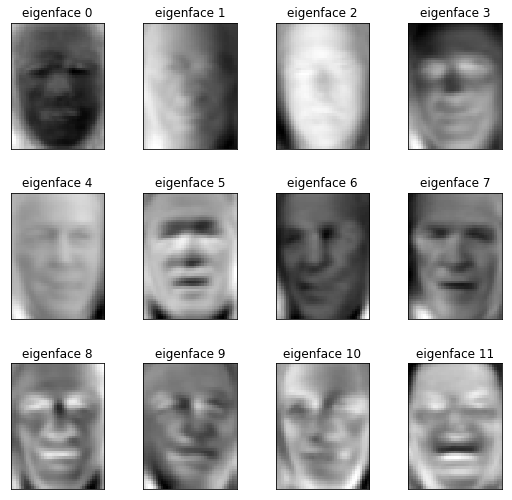

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 19 18:00:00 2018

@author: Jesús García
"""

from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


print(__doc__)

# Display progress logs on stdout
print("ponemos la info a DEBUG para tener todas las informaciones utiles  ")
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(message)s')
# puedo eligir entre:  DEBUG - INFO - WARNING - ERROR - CRITICAL


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays
print("descargando si no está en el disco... ")
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


print("-------------------- ")
print("Step  >>>> Split into a training set and a test set using a stratified k fold  ")
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)
#original >>> random_state=42)
# info about random state, why ever same faces
#https://stackoverflow.com/questions/28064634/random-state-pseudo-random-numberin-scikit-learn

# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

print("-------------------- ")
print("Step  >>>>  Compute a PCA   ")
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model
print("-------------------- ")
print("Step  >>>>  Train a SVM classification model  ")
t0 = time()
param_grid_MLP = {'alpha': [1e-3, 5e-3, 1e-4, 5e-4, 1e-5],
              'hidden_layer_sizes': [(10,10),(20,20),(30,30)], }
clf_MLP = GridSearchCV(MLPClassifier(), param_grid_MLP)
clf_MLP = clf_MLP.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_MLP.best_estimator_)


print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set
print("-------------------- ")
print("Step  >>>>   PREDICTING    ")
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

print("-------------------- ")
print("Step  >>>>   PREDICTING    ")
print("Predicting people's names on the test set")
t0 = time()
y_pred_MLP = clf_MLP.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred_MLP, target_names=target_names))
print(confusion_matrix(y_test, y_pred_MLP, labels=range(n_classes)))




# #############################################################################
# Qualitative evaluation of the predictions using matplotlib
print("-------------------- ")
print("Step  >>>>   Qualitative evaluation of the predictions using matplotlib    ")
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

print("-------------------- ")
print("Step  >>>>  SHOW SHOW SHOW SHOW SHOW SHOW SHOW    ")
plt.show()